# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [2]:
import numpy as np
import pandas as pd

from scipy.stats import beta, binom
import matplotlib.pyplot as plt

### Questão 1

In [3]:
def run(a, b, N = 10, N1 = 8):
    # Theta (eixo x)
    theta = np.linspace(0.0, 1.0, 150)

    #
    ML   = N1/N
    MAP  = (a + N1 - 1)/(a + b + N - 2)
    APOS = (a + N1)/(a + b + N)
    
    # Priori
    priori = beta.pdf(theta, a, b)
    # Posteriori
    posteriori = beta.pdf(theta, N1 + a, N - N1 + b)
    # Verossimilhança
    likelihood = theta**N1 * (1-theta)**(N-N1)
    likelihood /= max(likelihood)  # O carinha da estatística que falou para normalizar

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(theta, priori, label=f'Priori $\\rightarrow$ p($\\theta$) = Beta($\\theta$|a={a}, b={b})', color='green')
    plt.plot(theta, posteriori, label=f'Posteriori: $\\rightarrow$ p($\\theta|D$) = Beta($\\theta$|a={N1 + a}, b={N - N1 + b})', color='red')
    plt.plot(theta, likelihood, label=f'Verossimilhança: $\\rightarrow$ p($D|\\theta$) = $\\theta^{{N1}}(1-\\theta)^{{N-N1}}$', color='blue')

    # Marcas
    plt.vlines(x=ML, ymin=0, ymax=3.5, ls=':', color='black')
    plt.vlines(x=MAP, ymin=0, ymax=3.5, ls=':', color='gray')
    plt.vlines(x=APOS, ymin=0, ymax=3.5, ls=':', color='silver')
    
    # Plot info
    plt.title(f'$a={a}, b={b},$\n$\\theta_{{ML}}={ML:.2}, \\theta_{{MAP}}={MAP:.2}, \\mathbb{{E}}[\\theta|D]$={APOS:.2}')
    plt.xlabel('θ')
    plt.ylabel('Densidade de Probabilidade')
    
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.show()

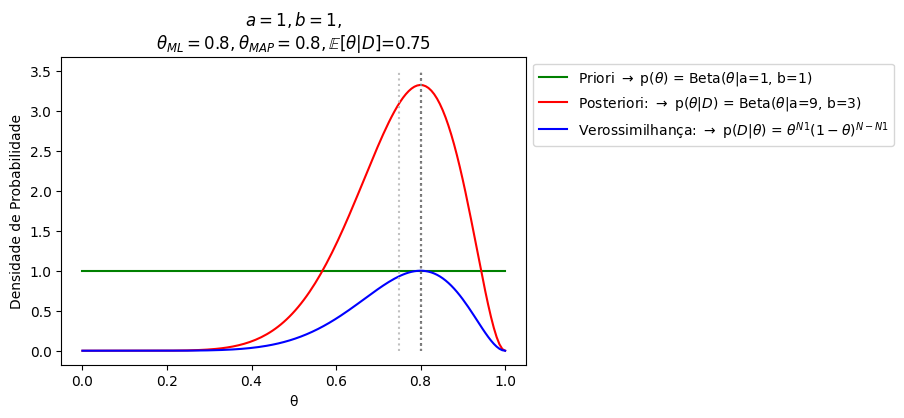

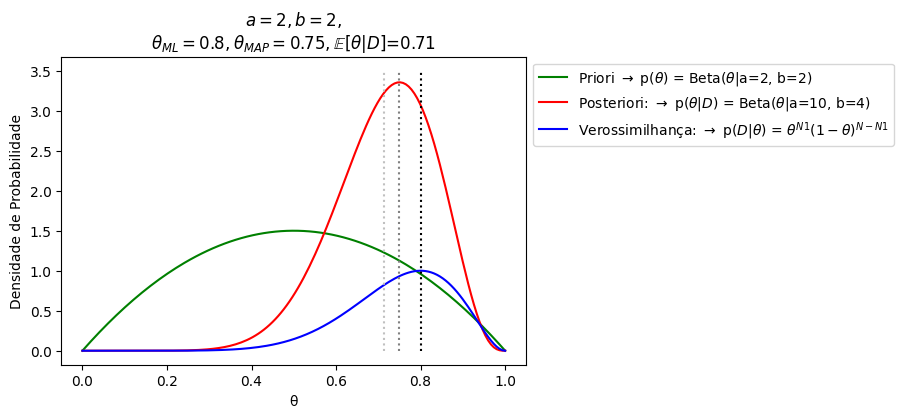

In [4]:
run(1, 1)
run(2, 2)

### Questão 2

In [103]:
import time
import random as rnd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Dados (3 classes)
data = pd.read_csv('./files/cleaned_reviews.csv').dropna()
X = data.cleaned_review
y = LabelEncoder().fit_transform(data.sentiments)

In [123]:
def run(X, y, a, b, alpha = 10, train_size=1000, random_state=None, verbose=False):
    # Split
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=train_size, random_state=random_state)
    
    # Counts
    classes, counts = np.unique(y_train, return_counts=True)
    idxc = [np.where(y_train == c)[0] for c in classes]
    
    if (verbose):
        print(f'# Train: {X_train.shape[0]} {{{", ".join([f"{c} → {count}" for c, count in zip(classes, counts)])}}}') # N
        print(f'# Test:  {X_test.shape[0]}')
    
    # 
    encoder = CountVectorizer(binary=True).fit(X_train)
    
    X_train = encoder.transform(X_train).toarray()
    X_test = encoder.transform(X_test).toarray()
    
    # Thetas
    theta = np.zeros((len(classes), X_train.shape[1]))
    
    for d in range(X_train.shape[1]):
        for c in classes:
            theta[c][d] = (sum(X_train[idxc[c]][:, d]) + b)/(counts[c] + a + b)
    
    # Alphas
    alpha = np.full(len(classes), alpha)
    
    # Pis                                            1
    pi = [(counts[c] + alpha[c])/(train_size + sum(alpha)) for c in classes]
    
    # Prediction
    y_pred = []
    for xstar in X_test:
        y_pred.append(
            np.argmax( \
                np.log(pi) + \
                np.sum(np.log(  theta[:, np.where(xstar==1)[0]]), axis=1) + \
                np.sum(np.log(1-theta[:, np.where(xstar==0)[0]]), axis=1) \
            )
        )
        
    return accuracy_score(y_test, y_pred)

def repeated_run(X, y, a, b, alpha = 10, train_size=1000, repetitions=20, verbose=False):
    times  = []
    scores = []
    for r in range(repetitions):
        start = time.time()
        
        accuracy = run(X, y, a, b, \
                    alpha=alpha, \
                    train_size=train_size, \
                    random_state=rnd.randint(0, 100000))
        
        end = time.time()
        times.append(end - start)
        scores.append(accuracy)

    
    print(f'# Alpha: {alpha}')
    print(f'# Beta: a={a}, b={b}')
    print(f'# Repetitions: {repetitions}')
    
    print('-'*40)
    print('# Accuracy')
    print(f'- Mean: {np.mean(scores):.4}')
    print(f'- Stdev: {np.std(scores):.4}')
    
    print('-'*40)
    print('# Time')
    print(f'- Total: {np.sum(times):.2}s')
    print(f'- Mean: {np.mean(times):.2}')
    print(f'- Stdev: {np.std(times):.2}')

In [124]:
rnd.seed(42)
repeated_run(X, y, 1, 1, repetitions=20)

# Alpha: 10
# Beta: a=1, b=1
# Repetitions: 20
----------------------------------------
# Accuracy
- Mean: 0.6773
- Stdev: 0.02307
----------------------------------------
# Time
- Total: 1.2e+02s
- Mean: 5.9
- Stdev: 0.56


In [125]:
repeated_run(X, y, 0.5, 0.5, repetitions=20)

# Alpha: 10
# Beta: a=0.5, b=0.5
# Repetitions: 20
----------------------------------------
# Accuracy
- Mean: 0.658
- Stdev: 0.02739
----------------------------------------
# Time
- Total: 1.2e+02s
- Mean: 5.8
- Stdev: 0.45


In [126]:
repeated_run(X, y, 2, 2, repetitions=20)

# Alpha: 10
# Beta: a=2, b=2
# Repetitions: 20
----------------------------------------
# Accuracy
- Mean: 0.6906
- Stdev: 0.01986
----------------------------------------
# Time
- Total: 1.1e+02s
- Mean: 5.4
- Stdev: 0.32


----

$$
y_* = \displaystyle\arg\,\underset{c}{\max} = \left[\log \bar\pi_c + \sum_{d|x_*d=1} \log\bar\theta_{dc} + \sum_{d|x_*d=0} \log(1 - \bar\theta_{dc})\right]
$$

$$
\bar\theta_{dc} = \frac{N_{dc} + b}{N_c + a + b}
$$

$$
\bar\pi_{c} = \frac{N_c + \alpha_c}{N + \sum_{c=1}^C \alpha_c}
$$

----

$$
\hat{w}_{ML} = \arg\,\underset{w}{\max}\ p(y|w,x)
$$

$$
\hat{w}_{MAP} = \arg\,\underset{w}{\max}\ p(y|w,x)p(w)
$$

$$
p(w|x,y) = \frac{p(y|w,x)p(w)}{p(x|y)},\ p(x|y) = \int p(y|w,x)p(w)\,dw
$$